In [1]:
import numpy as np
import torch
import open_clip
import csv
from tqdm import tqdm
import pandas
import matplotlib.pyplot as plt

/home/martin/Documents/MScProject/project_local/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
testsets = {
    "Progan" : ["progan_lsun"],
    "Biggan" : ["biggan_256","biggan_512"],
    "Gaugan" : ["gaugan"],
    "Stargan" : ["stargan"],
    "EG3D" : ["eg3d"],
    "Stylegan 2": ["stylegan2_afhqv2_512x512",
                   "stylegan2_ffhq_256x256",
                   "stylegan2_ffhq_1024x1024",
                   "stylegan2_lsundog_256x256",
                   "whichfaceisreal"],
    "Stylegan 3" : ["stylegan3_r_afhqv2_512x512",
                    "stylegan3_r_ffhqu_256x256",
                    "stylegan3_r_ffhqu_1024x1024",
                    "stylegan3_t_afhqv2_512x512",
                    "stylegan3_t_ffhqu_256x256",
                    "stylegan3_t_ffhqu_1024x1024"],
    "Taming Trans." : ["taming-transformers_class2image_ImageNet",
                             "taming-transformers_noise2image_FFHQ",
                             "taming-transformers_segm2image_valid"],
    "Dall-E Mini" : ["dalle-mini_valid"],
    "Dall-E 2" : ["dalle_2"],
    "Glide" : ["glide_text2img_valid"],
    "Guided Dif." : ["guided-diffusion_class2image_ImageNet",  
                "guided-diffusion_noise2image_LSUNbedrooms",
                "guided-diffusion_noise2image_LSUNcats",
                "guided-diffusion_noise2image_LSUNhorses"],
    "Latent Dif." : ["latent-diffusion_class2image_ImageNet",
                          "latent-diffusion_noise2image_FFHQ",
                          "latent-diffusion_noise2image_LSUNbedrooms",
                          "latent-diffusion_noise2image_LSUNchurches",
                          "latent-diffusion_text2img_valid"],
    "Stable Diff." : ["stable_diffusion_256"],
    "Stable Diff. v2" : ["stable_diffusion_512_50steps",
                             "stable_diffusion_512_100steps",
                             "stable_diffusion_512_200steps"],
    "DeepFakes" : ["deepfake"],
    "Pristine" : ["real_coco_valid", 
                  "real_imagenet_val", 
                  "real_ucid",
                  "ffhq",
                  "celebA",
                  ],
}

In [5]:
progan_openai_RC = pandas.read_csv("data/compressed/progan_openai.csv", header=0, index_col=0)
progan_laion_RC = pandas.read_csv("data/compressed/progan_laion.csv", header=0, index_col=0)
stable_openai_RC = pandas.read_csv("data/compressed/stable_openai.csv", header=0, index_col=0)
stable_laion_RC = pandas.read_csv("data/compressed/stable_laion.csv", header=0, index_col=0)
fused_openai_RC = pandas.read_csv("data/compressed/fused_openai.csv", header=0, index_col=0)
fused_laion_RC = pandas.read_csv("data/compressed/fused_laion.csv", header=0, index_col=0)

progan_openai = pandas.read_csv("data/progan-trained/vitL14_progan_openai_720k_net_accuracies.csv", header=0, index_col=0)
progan_laion = pandas.read_csv("data/progan-trained/vitH14_progan_laion_100k_net_accuracies.csv", header=0, index_col=0)
stable_openai = pandas.read_csv("data/stable-trained/vitL14_stable_100k_openai_net_accuracies.csv", header=0, index_col=0)
stable_laion = pandas.read_csv("data/stable-trained/vitH14_stable_100k_laion_net_accuracies.csv", header=0, index_col=0)
fused_openai = pandas.read_csv("data/fuse/progan+stable_vitL14_200k_openai_net_accuracy.csv", header=0, index_col=0)
fused_laion = pandas.read_csv("data/fuse/progan+stable_vitH14_200k_laion_net_accuracy.csv", header=0, index_col=0)

baseline = pandas.read_csv("data/grag_accuracies.csv", header=0, index_col=0)
baseline_RC = pandas.read_csv("data/grag_accuracies_RC.csv", header=0, index_col=0)

colors = {
    "Progan OpenAI RC": "gray",
    "Progan OpenAI": "green",
    "Progan LAION RC": "gray",
    "Progan LAION": "green",
    "Stable OpenAI RC": "gray",
    "Stable OpenAI": "orange",
    "Stable LAION RC": "gray",
    "Stable LAION": "orange",
    "FUSED OpenAI RC": "gray",
    "FUSED OpenAI": "purple",
    "FUSED LAION RC": "gray",
    "FUSED LAION": "purple",
    "Grag2021 ProGAN RC": "gray",
    "Grag2021 ProGAN": "blue",
    "Grag2021 Latent RC": "gray",
    "Grag2021 Latent": "blue",
}

allsubmodels = []
for key in testsets:
    allsubmodels = allsubmodels + testsets[key]
tab_metrics = pandas.DataFrame(index=list(allsubmodels), columns = colors.keys())

for key in allsubmodels:
    tab_metrics.loc[key, "Progan OpenAI RC"] = progan_openai_RC.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Progan OpenAI"] = progan_openai.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Progan LAION RC"] = progan_laion_RC.loc[key + ".pt", "0.15"]
    tab_metrics.loc[key, "Progan LAION"] = progan_laion.loc[key + ".pt", "0.50"]
    tab_metrics.loc[key, "Stable OpenAI RC"] = stable_openai_RC.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Stable OpenAI"] = stable_openai.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "Stable LAION RC"] = stable_laion_RC.loc[key + ".pt", "0.30"]
    tab_metrics.loc[key, "Stable LAION"] = stable_laion.loc[key + ".pt", "0.55"]
    tab_metrics.loc[key, "FUSED OpenAI RC"] = fused_openai_RC.loc[key + ".pt", "0.20"]
    tab_metrics.loc[key, "FUSED OpenAI"] = fused_openai.loc[key + ".pt", "0.40"]
    tab_metrics.loc[key, "FUSED LAION RC"] = fused_laion_RC.loc[key + ".pt", "0.10"]
    tab_metrics.loc[key, "FUSED LAION"] = fused_laion.loc[key + ".pt", "0.90"]

    tab_metrics.loc[key, "Grag2021 ProGAN RC"] = baseline_RC.loc[key, "Grag2021_progan"]
    tab_metrics.loc[key, "Grag2021 ProGAN"] = baseline.loc[key, "Grag2021_progan"]
    tab_metrics.loc[key, "Grag2021 Latent RC"] = baseline_RC.loc[key, "Grag2021_latent"]
    tab_metrics.loc[key, "Grag2021 Latent"] = baseline.loc[key, "Grag2021_latent"]

def plot_raw_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        measurement = tuple([m * 100 for m in measurement])
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.legend(loc='upper center', ncols=len(models))
    ax.set_ylim(0,115)
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()

def plot_mean_accuracy(sets, models, width=0.30, multiplier=-1):
    plot_sets = sets
    plot_models = models

    x = np.arange(len(plot_sets))

    fig, ax = plt.subplots(layout='constrained')
    fig.set_size_inches(18.5, 3.0)

    for model in plot_models:
        measurement = []
        for set in plot_sets:
            subsets = testsets[set]
            m = np.mean([tab_metrics.loc[subset, model] for subset in subsets])
            measurement.append(m)
        pristine_mean = np.mean([tab_metrics.loc[subset, model] for subset in testsets["Pristine"]])
        measurement = [(m+pristine_mean)/ 2 * 100 for m in measurement]
        GAN_accuracy = np.mean(measurement[0:7])
        VQGAN_accuracy = np.mean(measurement[7:9])
        DM_accuracy = np.mean(measurement[7:-2])
        mean_accuracy = np.mean(measurement[:-1])
        print(f"{model} : GAN({GAN_accuracy}) VQGAN({VQGAN_accuracy} DM({DM_accuracy}) MEAN({mean_accuracy})")
        measurement = tuple(measurement)
        offset = width * multiplier
        rects = ax.bar(x+offset, measurement, width, label=model, color = colors[model])
        ax.axhline(y = mean_accuracy, linestyle= ":", color=colors[model])
        multiplier += 1

    ax.set_ylabel("Accuracy")
    ax.set_xticks(x+width, plot_sets)
    ax.set_ylim(0,115)
    ax.legend(loc='upper center', ncols=len(models))
    ax.axhline(y = 50, color = 'r', linestyle = '--')
    ax.axhline(y = 100, color = 'black', linestyle = '-')

    plt.show()
    

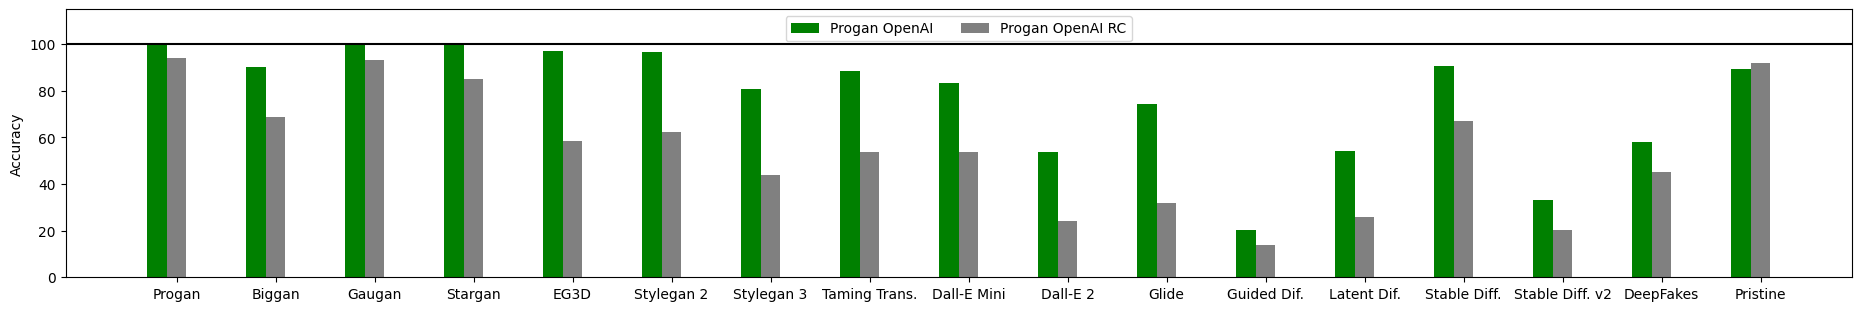

Progan OpenAI : GAN(92.16159178424802) VQGAN(87.65923504652176 DM(77.88477076080747) MEAN(83.43447374634957)
Progan OpenAI RC : GAN(82.09423103542827) VQGAN(72.89570771185294 DM(65.28493390232913) MEAN(72.51332415174365)


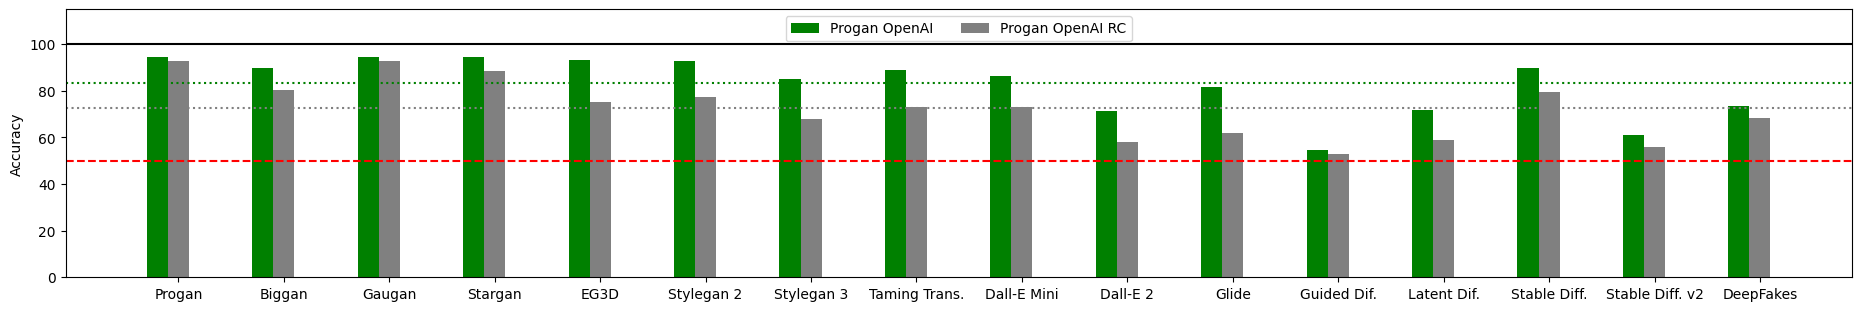

In [6]:
plot_sets = list(testsets.keys())
plot_models = ["Progan OpenAI", "Progan OpenAI RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

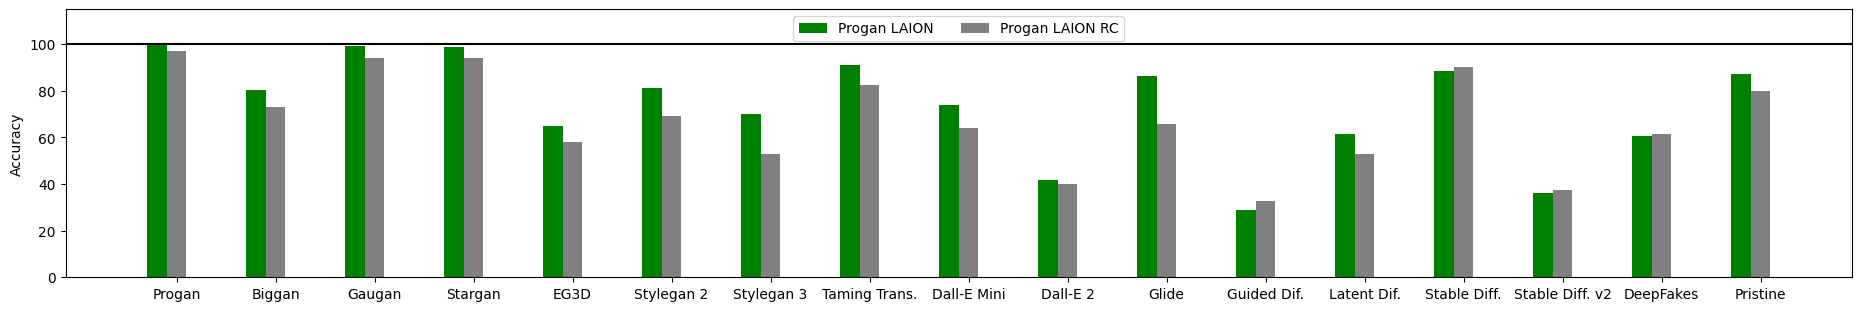

Progan LAION : GAN(86.13319187957894) VQGAN(84.84488631759825 DM(77.36161250807446) MEAN(80.41167891318925)
Progan LAION RC : GAN(78.44169661488338) VQGAN(76.60386910645158 DM(70.56446434454682) MEAN(73.44979972149753)


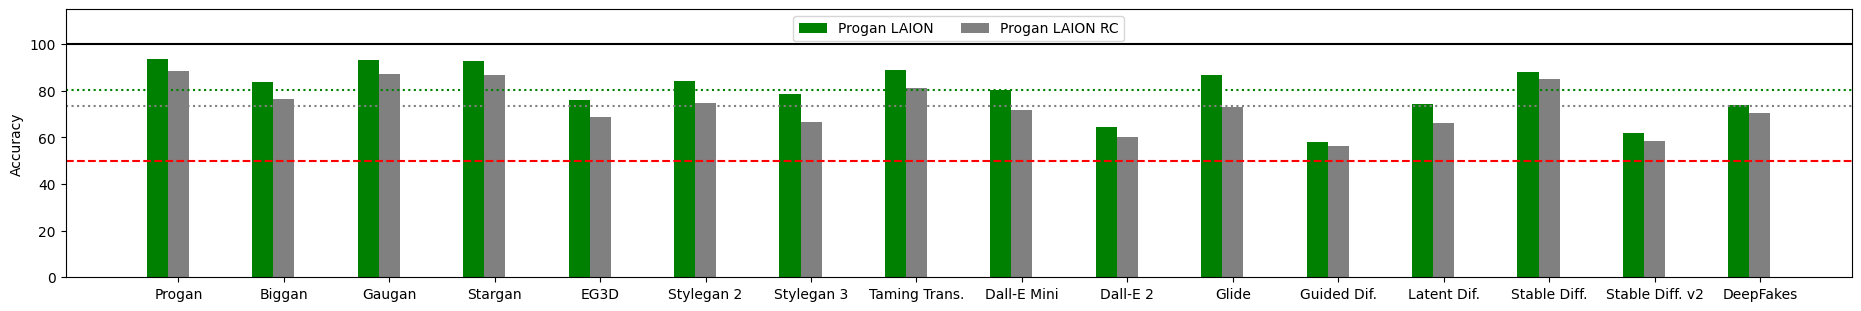

In [7]:
plot_sets = list(testsets.keys())
plot_models = ["Progan LAION", "Progan LAION RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

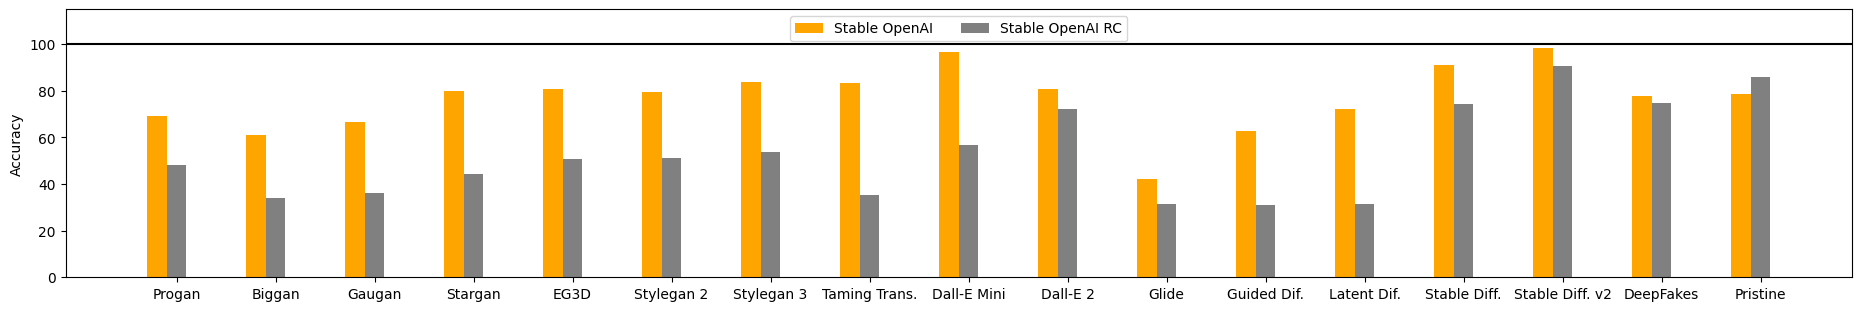

Stable OpenAI : GAN(76.63650430499649) VQGAN(84.38373423782144 DM(77.16492471401192) MEAN(77.68124915805869)
Stable OpenAI RC : GAN(65.6602218174841) VQGAN(65.8726095155201 DM(66.68171665837723) MEAN(67.6494119231033)


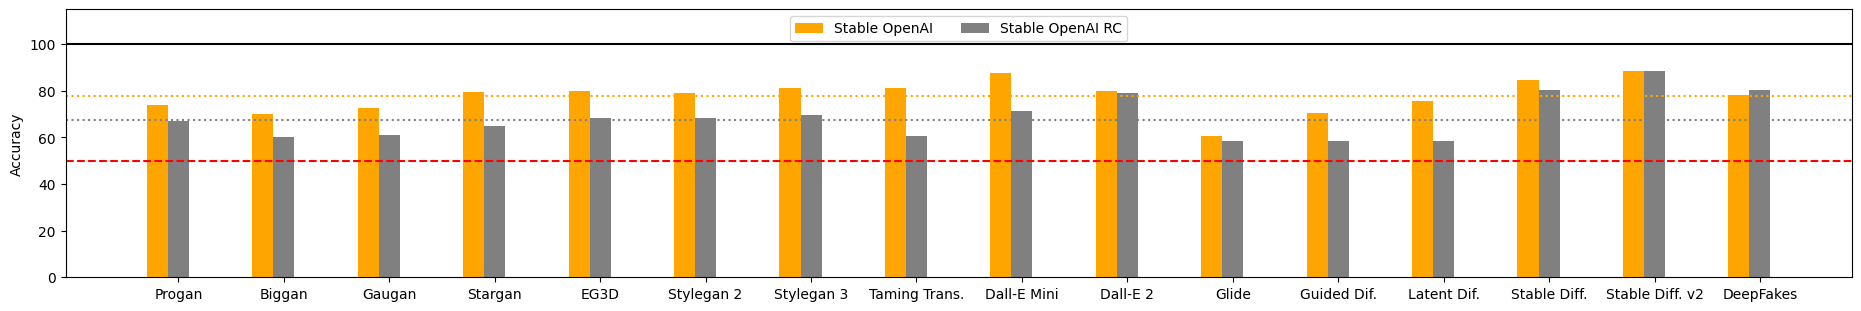

In [8]:
plot_sets = list(testsets.keys())
plot_models = ["Stable OpenAI", "Stable OpenAI RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

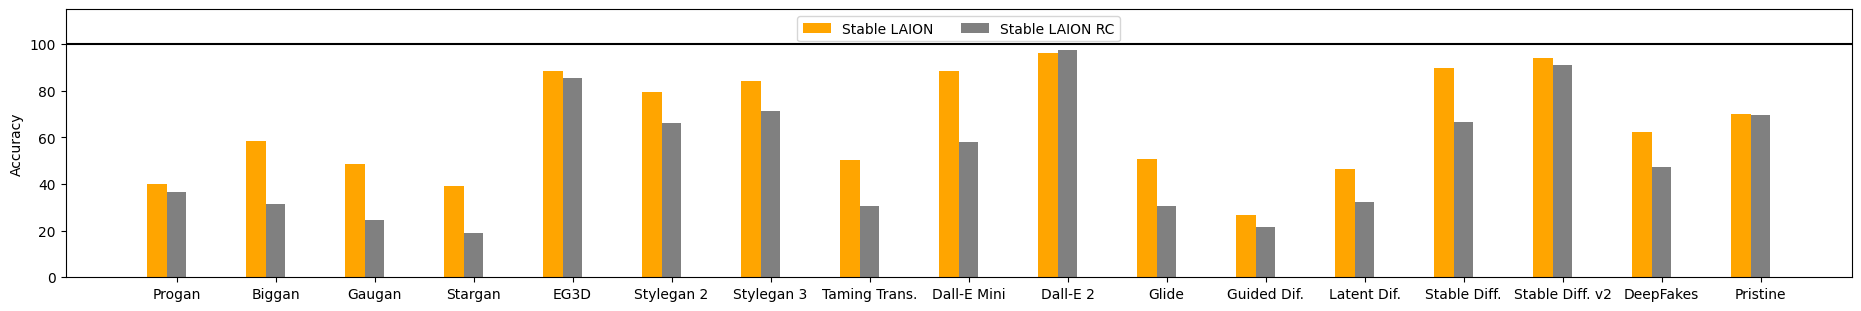

Stable LAION : GAN(66.26355483608333) VQGAN(69.65382639526041 DM(67.01281449049851) MEAN(67.6570052232)
Stable LAION RC : GAN(58.655725223958804) VQGAN(56.87811554357148 DM(58.79954411500006) MEAN(60.16488894997445)


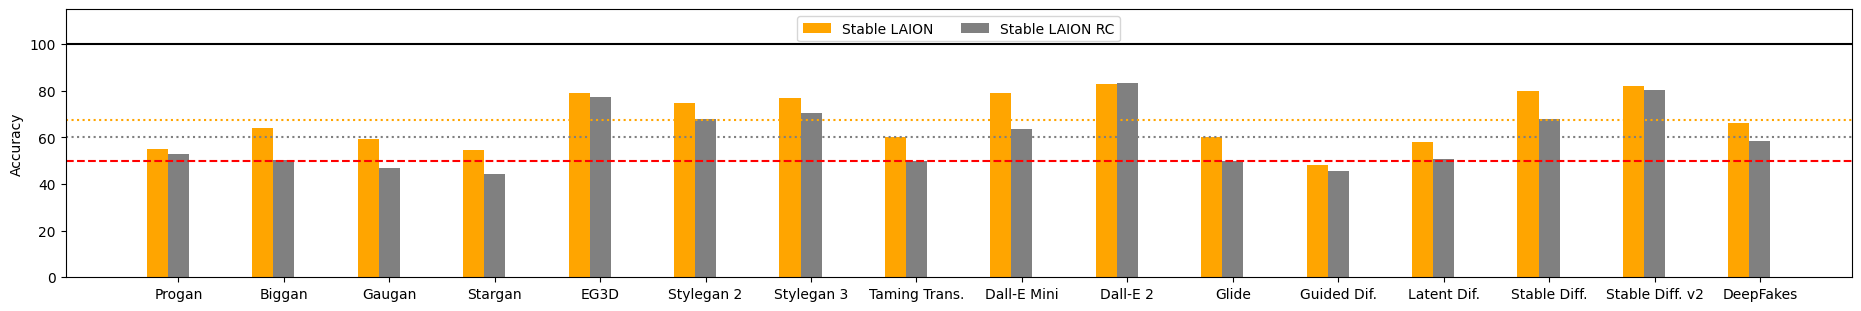

In [10]:
plot_sets = list(testsets.keys())
plot_models = ["Stable LAION", "Stable LAION RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

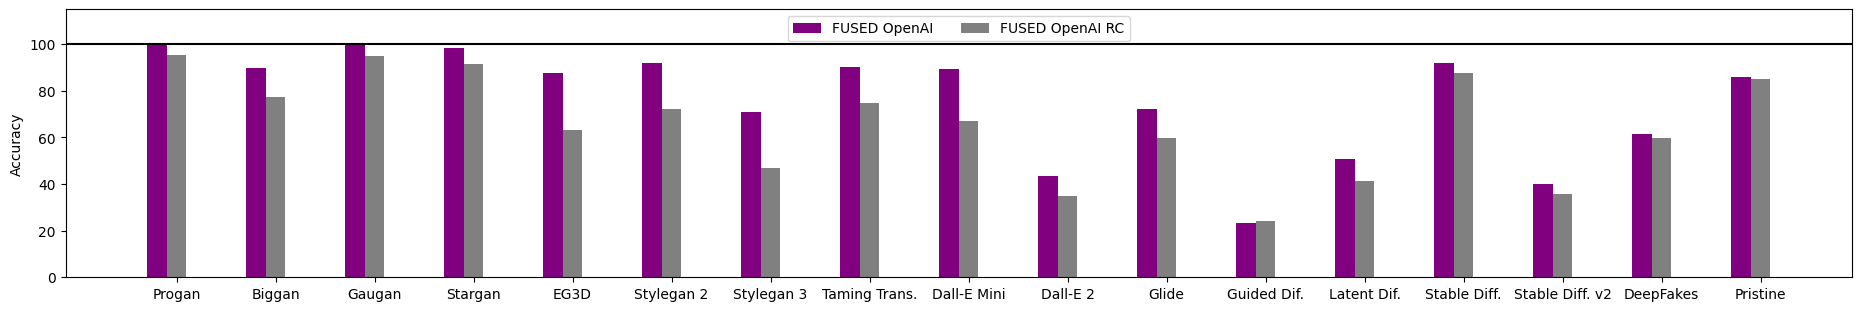

FUSED OpenAI : GAN(88.64781102496998) VQGAN(88.02212966572972 DM(76.02260585620591) MEAN(81.05600318893075)
FUSED OpenAI RC : GAN(81.16474437437348) VQGAN(77.97571184695488 DM(70.30648565647867) MEAN(74.70439924863912)


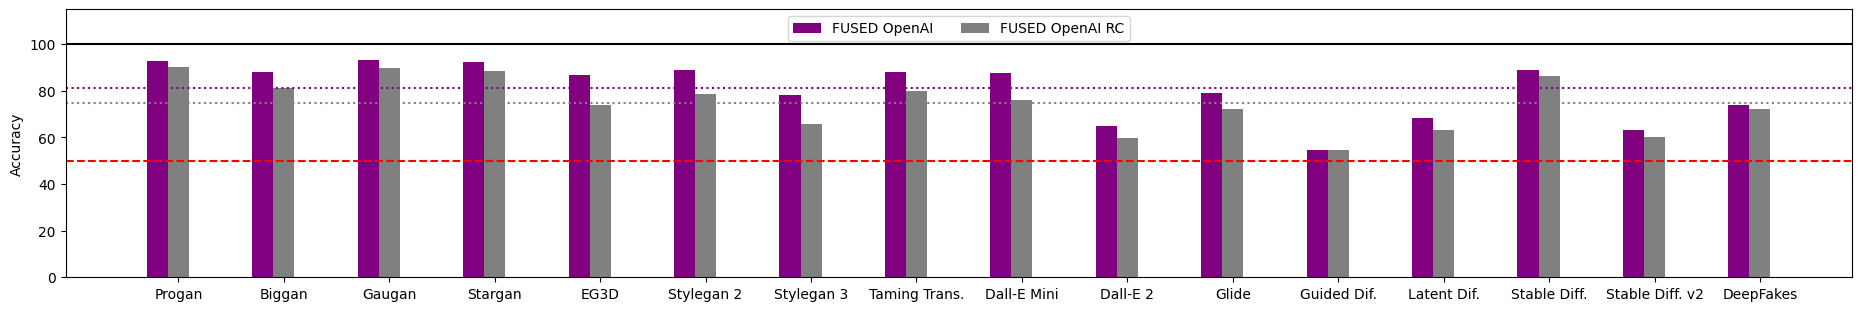

In [11]:
plot_sets = list(testsets.keys())
plot_models = ["FUSED OpenAI", "FUSED OpenAI RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

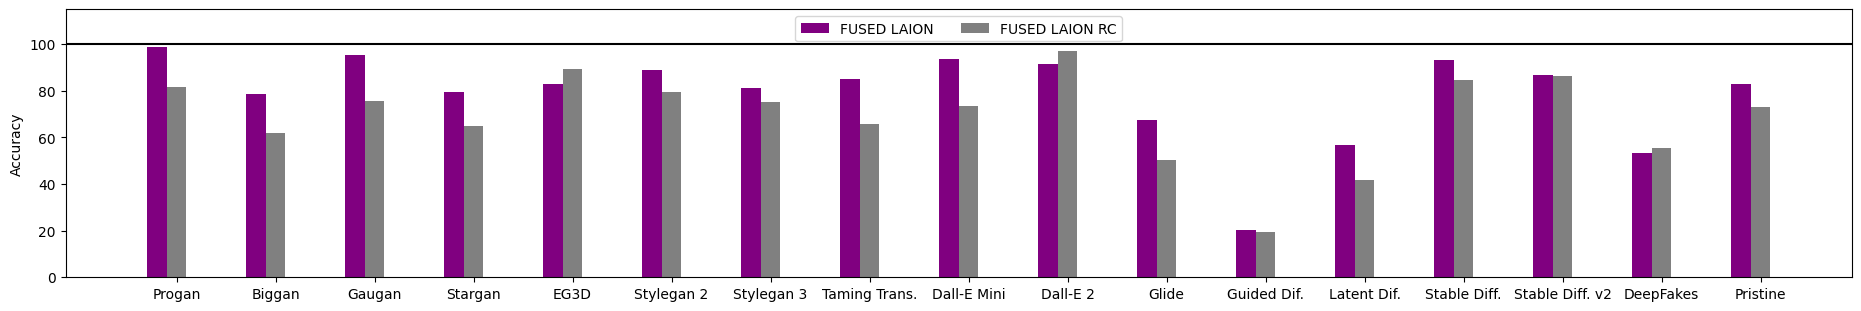

FUSED LAION : GAN(84.66135297203414) VQGAN(86.1342937215992 DM(77.70000800731349) MEAN(81.42147692735774)
FUSED LAION RC : GAN(74.24089988779464) VQGAN(71.35926461287444 DM(67.44337175573158) MEAN(71.43161107450386)


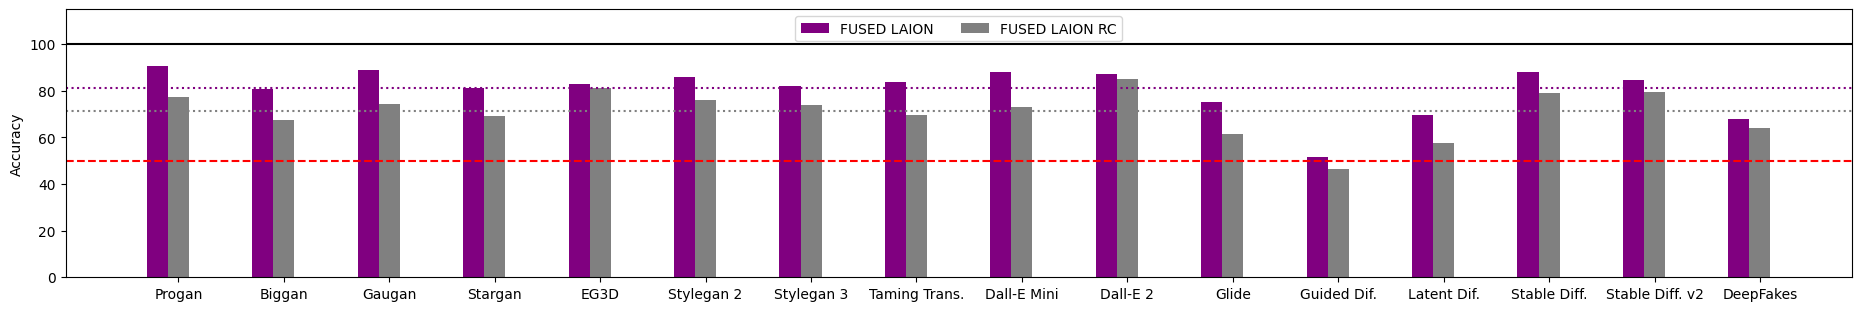

In [12]:
plot_sets = list(testsets.keys())
plot_models = ["FUSED LAION", "FUSED LAION RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

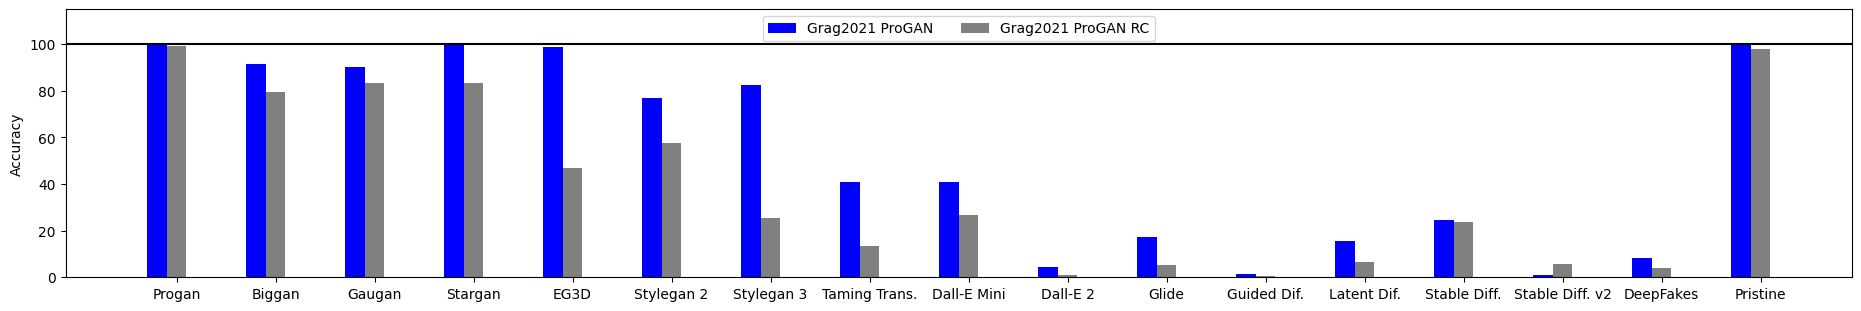

Grag2021 ProGAN : GAN(95.5696034581881) VQGAN(70.34995747873937 DM(60.22031462159651) MEAN(76.05140338025988)
Grag2021 ProGAN RC : GAN(82.9851972546148) VQGAN(59.077 DM(54.51807142857143) MEAN(67.62276982993136)


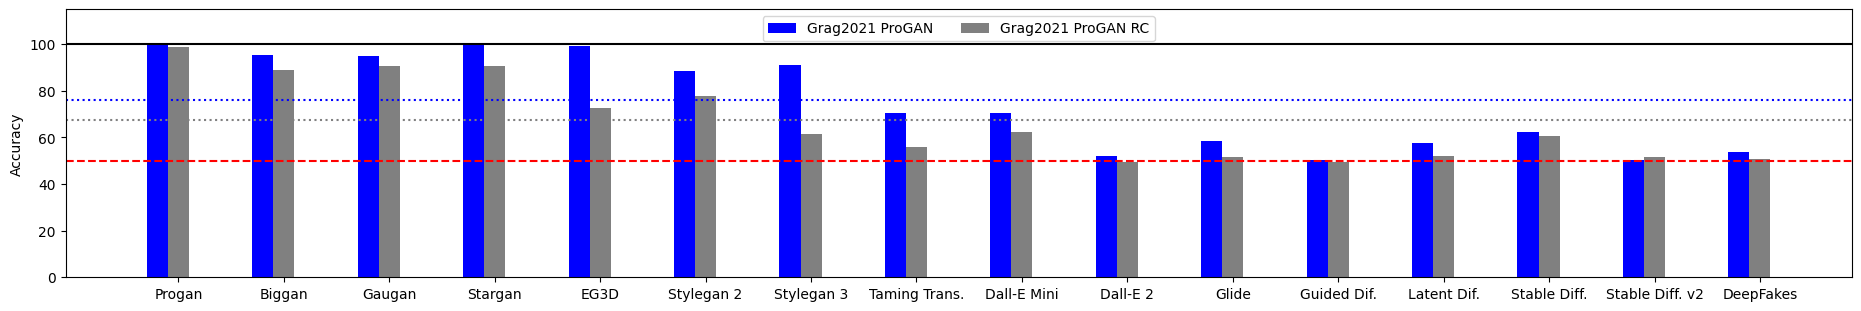

In [13]:
plot_sets = list(testsets.keys())
plot_models = ["Grag2021 ProGAN", "Grag2021 ProGAN RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

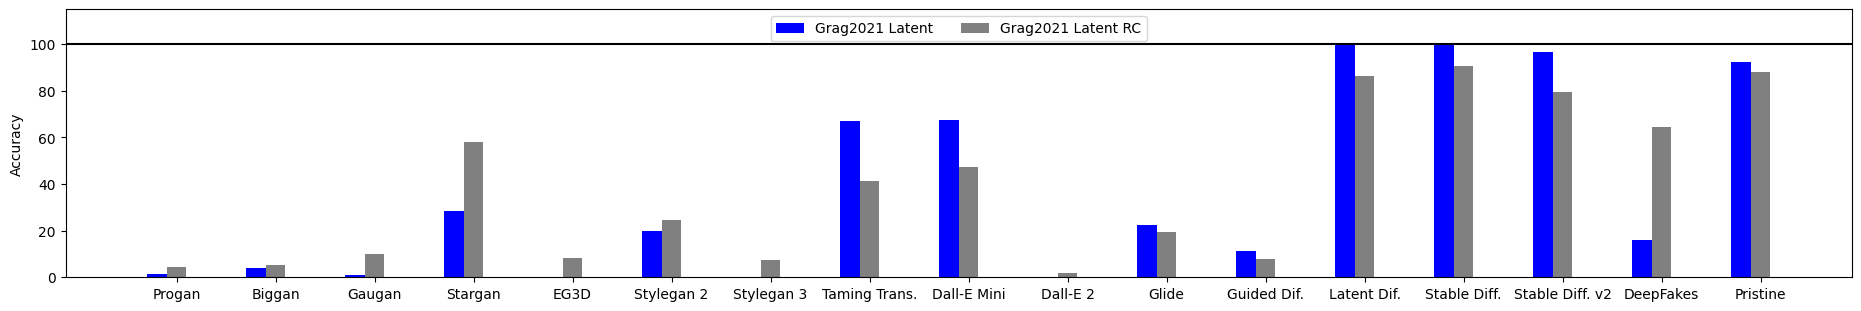

Grag2021 Latent : GAN(50.21630886872008) VQGAN(79.98481073870269 DM(72.61487026251221) MEAN(63.62187097715524)
Grag2021 Latent RC : GAN(52.40228470048659) VQGAN(66.18633333333332 DM(65.04984523809523) MEAN(60.393416193560405)


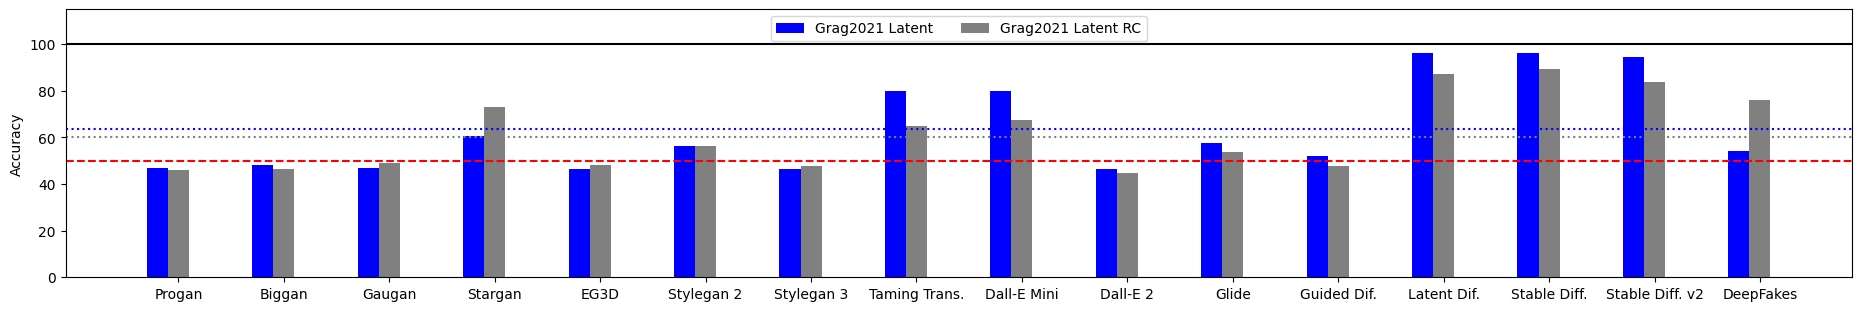

In [14]:
plot_sets = list(testsets.keys())
plot_models = ["Grag2021 Latent", "Grag2021 Latent RC"]

plot_raw_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)

plot_sets = list(testsets.keys())[:-1]
plot_mean_accuracy(plot_sets, plot_models, multiplier=0, width=0.20)